In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
import numpy as np
from matplotlib.pyplot import figure

everything = pd.read_csv('worldcities.csv')
everything = everything.drop_duplicates(subset=['lat', 'lng'])
everything = everything.reset_index()
countries = everything.get('country')
cities = everything.get('city')

In [2]:
length = len(everything)
ordered = {}

for i in range(length):
    if countries[i] in ordered:
        ordered[countries[i]].append(cities[i])
    else:
        ordered[countries[i]] = [cities[i]]

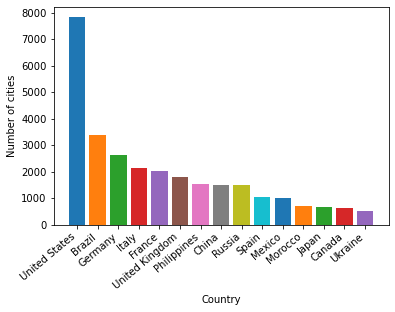

In [3]:
ordered = OrderedDict(sorted(ordered.items(), key = lambda x: len(x[1]), reverse=True))
maxlen = len(list(ordered.items())[0][1])

for i in range(15):
    tot = len(list(ordered.items())[i][1])
    plt.bar(list(ordered.items())[i][0], tot)


plt.xticks(rotation=40, ha='right')
plt.xlabel('Country')
plt.ylabel('Number of cities')
plt.show()

In [4]:
for city in ordered.items():
    for i in range(maxlen - len(city[1])):
        city[1].append(' ')

In [5]:
ordered = pd.DataFrame(ordered)
ordered.to_csv('new_cities.csv', index=False)

In [6]:
print(pd.read_csv('new_cities.csv'))

         United States          Brazil    Germany    Italy     France  \
0             New York       São Paulo     Berlin     Rome      Paris   
1          Los Angeles  Rio de Janeiro    Hamburg    Milan       Nice   
2              Chicago  Belo Horizonte     Munich   Naples   Toulouse   
3                Miami        Brasília    Cologne    Turin  Marseille   
4               Dallas        Salvador  Frankfurt  Palermo     Rennes   
...                ...             ...        ...      ...        ...   
7818         Ridgeland                                                  
7819            Dwight                                                  
7820  Oak Park Heights                                                  
7821         Gillespie                                                  
7822          Midfield                                                  

     United Kingdom    Philippines      China            Russia      Spain  \
0            London         Manila   Shanghai

In [7]:
def coord2dist(lat1, long1, lat2, long2):
    R = 6371
    φ1 = lat1 * math.pi/180
    φ2 = lat2 * math.pi/180
    Δφ = (lat2-lat1) * math.pi/180
    Δλ = (long2-long1) * math.pi/180

    
    a = np.sin(Δφ/2) * np.sin(Δφ/2) + np.cos(φ1) * np.cos(φ2) * np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return(R * c)

In [8]:
a=np.array([340, 180])
print(180-abs(abs(a)-180))

[ 20 180]


In [9]:
def dist(lat1, lat2, long1, long2):
    lat = lat1-lat2
    long = long1-long2
    long = (180-abs(abs(long)-180))
    return(lat*lat+long*long)

In [10]:
def diff(num1, num2):
    return(abs(num1-num2))

10000
9000
8000
7000
6000
5000
4000
3000
2000
1000


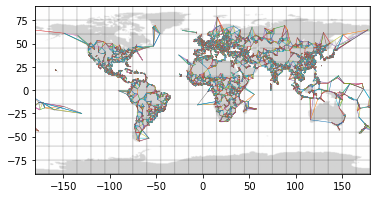

In [11]:
numcity = 10000
reduced = everything.head(numcity)
redlen = numcity

lats = np.array(reduced.get('lat'))
longs = np.array(reduced.get('lng'))
city = reduced.get('city')

close = {}

for j in range(numcity):
    closest = np.column_stack((range(numcity), dist(lats, lats[j], longs, longs[j])))
    closest = closest[closest[:,1].argsort()]
    closest = closest[1:,:]
    copy = 0
    
    if city[j]+str(0) in close:
        finish = False
        i=1
        while finish == False:
            if city[j]+str(i) in close:
                i+=1
            else:
                finish = True
        copy+=1      

    close[(city[j]+str(copy)).title()] = [[city[closest[1][0]], ("%.2f" % coord2dist(lats[int(closest[1][0])], longs[int(closest[1][0])], lats[j], longs[j]))]]
    for i in range(2,6):
        close[(city[j]+str(copy)).title()].append([city[closest[i][0]], ("%.2f" % coord2dist(lats[int(closest[i][0])], longs[int(closest[i][0])], lats[j], longs[j]))])
    
    for i in range(5):
        if diff(longs[j], longs[int(closest[i][0])])<180:
            plt.plot([longs[j], longs[int(closest[i][0])]], [lats[j], lats[int(closest[i][0])]], linewidth=0.5)
        elif longs[j]>longs[int(closest[i][0])]:
            plt.plot([longs[j], longs[int(closest[i][0])]+360], [lats[j], lats[int(closest[i][0])]], linewidth=0.5)
            plt.plot([longs[j]-360, longs[int(closest[i][0])]], [lats[j], lats[int(closest[i][0])]], linewidth=0.5)
        else:
            plt.plot([longs[j]+360, longs[int(closest[i][0])]], [lats[j], lats[int(closest[i][0])]], linewidth=0.5)
            plt.plot([longs[j], longs[int(closest[i][0])]-360], [lats[j], lats[int(closest[i][0])]], linewidth=0.5)
        
    if not(j%1000):
        print(numcity - j)


plt.xlim(-180, 180)
plt.ylim(-90,90)
img = plt.imread("worldmap.png")
plt.imshow(img, extent=[-180, 180, -90, 90])

plt.savefig('connectedworld.png', dpi=400)


In [12]:
name = input("Which city would you like to check? ").title()

if name not in set(reduced['city']):
    finish = False
    while finish == False:
        name = input("Please enter a valid city: ").title()
        if name in set(reduced['city']):
            finish = True
            
options = reduced.loc[reduced['city'] == name]
if len(options) > 1:
    print('Which ' + name + ' did you want? ')
    for i in range(len(options)):
        print(str(i+1) + '. ' + list(options['city'])[i] + ', ' + list(options['admin_name'])[i] + ', ' + list(options['country'])[i])
    choice = input('Enter which number: ')
    try:
        choice = int(choice) - 1
    except ValueError:
        choice=choice
    if choice not in range(len(options)):
        finish = False
        while finish == False:
            choice = input('Please enter a valid number: ')
            try:
                choice = int(choice) - 1
            except ValueError:
                choice=choice
            if choice in range(len(options)):
                finish = True
else:
    choice = 0

print('The closest cities to ' + list(options['city'])[choice] + ', ' + list(options['admin_name'])[choice] + ', ' + list(options['country'])[choice] + ' are:')
for res in close.get(name + str(choice)):
    print('{}{}'.format(res[0].ljust(15), 'which is ' + res[1] + 'km away'))


Which city would you like to check? London
Which London did you want? 
1. London, London, City of, United Kingdom
2. London, Ontario, Canada
Enter which number: 1
The closest cities to London, London, City of, United Kingdom are:
Lambeth        which is 1.96km away
Islington      which is 4.44km away
Brixton        which is 5.14km away
Spitalfields   which is 3.78km away
Highbury       which is 5.41km away


In [13]:
#Alternative method below

#numcity = 1000
#reduced = everything.head(numcity)

# lats = np.array(reduced.get('lat'))
# longs = np.array(reduced.get('lng'))

# close = {}
# tree = np.array([[0,0,0]])
# treeedge = [0]
# current = 0

# for j in range(numcity-1):
#     temp = []
#     for i in [x for x in range(numcity) if x not in treeedge]:
#         temp.append([current, i, dist(lats[i], lats[current], longs[i], longs[current])])
#     tree = np.concatenate((tree, temp))
#     tree = tree[tree[:,2].argsort()]
    
#     if j == 0:
#         tree = tree[1:, :]
    
#     current = int(tree[0][1])
#     treeedge.append(current)
#     plt.plot([longs[int(tree[0][0])], longs[current]], [lats[int(tree[0][0])], lats[current]], linewidth=0.5)
#     tree = np.delete(tree, np.where(tree[:,1]==current)[0], axis = 0)
    
#     if not(j%100):
#         print(numcity - j)

# plt.xlim(-180, 180)
# plt.ylim(-90,90)
# img = plt.imread("worldmap.png")
# plt.imshow(img, extent=[-180, 180, -90, 90])

# plt.savefig('minconnected.png', dpi=400)

In [ ]:
numcity = 4000
reduced = everything.head(numcity)
redlen = numcity

lats = np.array(reduced.get('lat'))
longs = np.array(reduced.get('lng'))
city = reduced.get('city')

close = {}
tree = []
current = 0
whichtree = []
inwhich = list(range(numcity))
edgelist=[[-1]]*numcity

for j in range(numcity):
    for i in np.array(range(numcity-j-1))+j+1:
        tree.append([j, i, dist(lats[i], lats[j], longs[i], longs[j])])
    whichtree.append([j])
    
tree=np.array(tree)
tree = tree[tree[:,2].argsort()]

i = 0
count = 0
while count < numcity-1:
    op1 = int(tree[i][0])
    op2 = int(tree[i][1])
    which1 = inwhich[op1]
    which2 = inwhich[op2]
    if op1 not in whichtree[which2]:
        whichtree[which2] = whichtree[which2] + whichtree[which1]
        temp=inwhich[op1]
        for j in whichtree[inwhich[op1]]:
            inwhich[j] = inwhich[op2]
        whichtree[temp] = []
        
        if diff(longs[op1], longs[op2])<180:
            plt.plot([longs[op1], longs[op2]], [lats[op1], lats[op2]], linewidth=0.5)
        elif longs[op1]>longs[op2]:
            plt.plot([longs[op1], longs[op2]+360], [lats[op1], lats[op2]], linewidth=0.5)
            plt.plot([longs[op1]-360, longs[op2]], [lats[op1], lats[op2]], linewidth=0.5)
        else:
            plt.plot([longs[op1]+360, longs[op2]], [lats[op1], lats[op2]], linewidth=0.5)
            plt.plot([longs[op1], longs[op2]-360], [lats[op1], lats[op2]], linewidth=0.5)
            
            
        count+=1
        edgelist[op1] = edgelist[op1] + [op2]
        edgelist[op2] = edgelist[op2] + [op1]

    i+=1   

plt.xlim(-180, 180)
plt.ylim(-90,90)
img = plt.imread("worldmap.png")
plt.imshow(img, extent=[-180, 180, -90, 90])

plt.savefig('minconnected2.png', dpi=400)

In [ ]:
done = [-1, 0]
previous = -1
current = 0

for i in range(2*(numcity-1)):
    nex = [x for x in edgelist[current] if x not in done]
    try: nex = nex[0]
    except: 
        nex = edgelist[current][1]

    edgelist[current].remove(nex)
    done = done + [nex]
    previous = current
    current = nex

done = list(dict.fromkeys(done[1:]))
for i in range(numcity):
    #plt.plot([longs[done[i-1]], longs[done[i]]], [lats[done[i-1]], lats[done[i]]], linewidth=0.5)
    
    if diff(longs[done[i-1]], longs[done[i]])<180:
        plt.plot([longs[done[i-1]], longs[done[i]]], [lats[done[i-1]], lats[done[i]]], linewidth=0.5)
    elif longs[done[i-1]]>longs[done[i]]:
        plt.plot([longs[done[i-1]], longs[done[i]]+360], [lats[done[i-1]], lats[done[i]]], linewidth=0.5)
        plt.plot([longs[done[i-1]]-360, longs[done[i]]], [lats[done[i-1]], lats[done[i]]], linewidth=0.5)
    else:
        plt.plot([longs[done[i-1]]+360, longs[done[i]]], [lats[done[i-1]], lats[done[i]]], linewidth=0.5)
        plt.plot([longs[done[i-1]], longs[done[i]]-360], [lats[done[i-1]], lats[done[i]]], linewidth=0.5)

plt.xlim(-180, 180)
plt.ylim(-90,90)
img = plt.imread("worldmap.png")
plt.imshow(img, extent=[-180, 180, -90, 90])

plt.savefig('worldcycle.png', dpi=400)